## Use Case Overview: 

The objective of this notebook is to predict the duration of NYC taxi trips. \
We use data related to yellow or green taxis to train a simple prediction model.

In this notebook, we use:

- Yellow taxi data from January 2021 for model training.
- Data from February 2021 to test the model (make predictions).

**Features for Model Training**: Useful variables related to the trip itself 

**Target to Predict**: The duration of the trip


### Data
Data for the whole course can be downloaded following this [link](https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page) or using the following code:



In [31]:
conda activate nyc-taxi


Note: you may need to restart the kernel to use updated packages.



CondaError: Run 'conda init' before 'conda activate'



In [32]:
%pip install gdown

Note: you may need to restart the kernel to use updated packages.


In [29]:
import gdown
import os

DATA_FOLDER = "../../data"
train_path = f"{DATA_FOLDER}/yellow_tripdata_2021-01.parquet"
test_path = f"{DATA_FOLDER}/yellow_tripdata_2021-02.parquet"
predict_path = f"{DATA_FOLDER}/yellow_tripdata_2021-03.parquet"


if not os.path.exists(DATA_FOLDER):
    os.makedirs(DATA_FOLDER)
    print(f"New directory {DATA_FOLDER} created!")

gdown.download(
    "https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2021-01.parquet",
    train_path,
    quiet=False,
)
gdown.download(
    "https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2021-02.parquet",
    test_path,
    quiet=False,
)
gdown.download(
    "https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2021-03.parquet",
    predict_path,
    quiet=False,
)

Downloading...
From: https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2021-01.parquet
To: c:\Users\c\10.9\esilv-mlops-crashcourse-24\data\yellow_tripdata_2021-01.parquet
100%|██████████| 21.7M/21.7M [00:00<00:00, 43.8MB/s]
Downloading...
From: https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2021-02.parquet
To: c:\Users\c\10.9\esilv-mlops-crashcourse-24\data\yellow_tripdata_2021-02.parquet
100%|██████████| 21.8M/21.8M [00:00<00:00, 22.3MB/s]
Downloading...
From: https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2021-03.parquet
To: c:\Users\c\10.9\esilv-mlops-crashcourse-24\data\yellow_tripdata_2021-03.parquet
100%|██████████| 30.0M/30.0M [00:01<00:00, 25.2MB/s]


'../../data/yellow_tripdata_2021-03.parquet'

In [30]:
import os

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import warnings

warnings.filterwarnings("ignore")

**Info** : <p style=color:green>Using large amounts of data in jupyter notebook, some cell can take some time to run<p/>

# 1 - Load data

In [8]:
DATA_FOLDER = "../../data"

train_df = pd.read_parquet(os.path.join(DATA_FOLDER, "yellow_tripdata_2021-01.parquet"))

In [9]:
train_df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,2021-01-01 00:30:10,2021-01-01 00:36:12,1.0,2.10,1.0,N,142,43,2,8.0,3.0,0.5,0.00,0.0,0.3,11.80,2.5,NaN
1,1,2021-01-01 00:51:20,2021-01-01 00:52:19,1.0,0.20,1.0,N,238,151,2,3.0,0.5,0.5,0.00,0.0,0.3,4.30,0.0,NaN
2,1,2021-01-01 00:43:30,2021-01-01 01:11:06,1.0,14.70,1.0,N,132,165,1,42.0,0.5,0.5,8.65,0.0,0.3,51.95,0.0,NaN
3,1,2021-01-01 00:15:48,2021-01-01 00:31:01,0.0,10.60,1.0,N,138,132,1,29.0,0.5,0.5,6.05,0.0,0.3,36.35,0.0,NaN
4,2,2021-01-01 00:31:49,2021-01-01 00:48:21,1.0,4.94,1.0,N,68,33,1,16.5,0.5,0.5,4.06,0.0,0.3,24.36,2.5,NaN


In [10]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1369769 entries, 0 to 1369768
Data columns (total 19 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   VendorID               1369769 non-null  int64         
 1   tpep_pickup_datetime   1369769 non-null  datetime64[us]
 2   tpep_dropoff_datetime  1369769 non-null  datetime64[us]
 3   passenger_count        1271417 non-null  float64       
 4   trip_distance          1369769 non-null  float64       
 5   RatecodeID             1271417 non-null  float64       
 6   store_and_fwd_flag     1271417 non-null  object        
 7   PULocationID           1369769 non-null  int64         
 8   DOLocationID           1369769 non-null  int64         
 9   payment_type           1369769 non-null  int64         
 10  fare_amount            1369769 non-null  float64       
 11  extra                  1369769 non-null  float64       
 12  mta_tax                13697

In [11]:
train_df.isnull().sum()

VendorID                       0
tpep_pickup_datetime           0
tpep_dropoff_datetime          0
passenger_count            98352
trip_distance                  0
RatecodeID                 98352
store_and_fwd_flag         98352
PULocationID                   0
DOLocationID                   0
payment_type                   0
fare_amount                    0
extra                          0
mta_tax                        0
tip_amount                     0
tolls_amount                   0
improvement_surcharge          0
total_amount                   0
congestion_surcharge       98352
airport_fee              1369764
dtype: int64

# 2 - Prepare the data

## 2-1 Compute the target

The dataset contains pickup and dropoff time but not the duration itself. \
We compute the duration of a taxi trip in minutes using these two variables.

In [13]:
def compute_target(df):
    df["duration"] = df["tpep_dropoff_datetime"] - df["tpep_pickup_datetime"]
    df["duration"] = df["duration"].dt.total_seconds() / 60
    return df


train_df = compute_target(train_df)

We can visualise how the duration is distributed : 

In [14]:
train_df["duration"].describe()

count    1.369769e+06
mean     1.391168e+01
std      1.312006e+02
min     -1.350846e+05
25%      5.566667e+00
50%      9.066667e+00
75%      1.461667e+01
max      2.881770e+04
Name: duration, dtype: float64

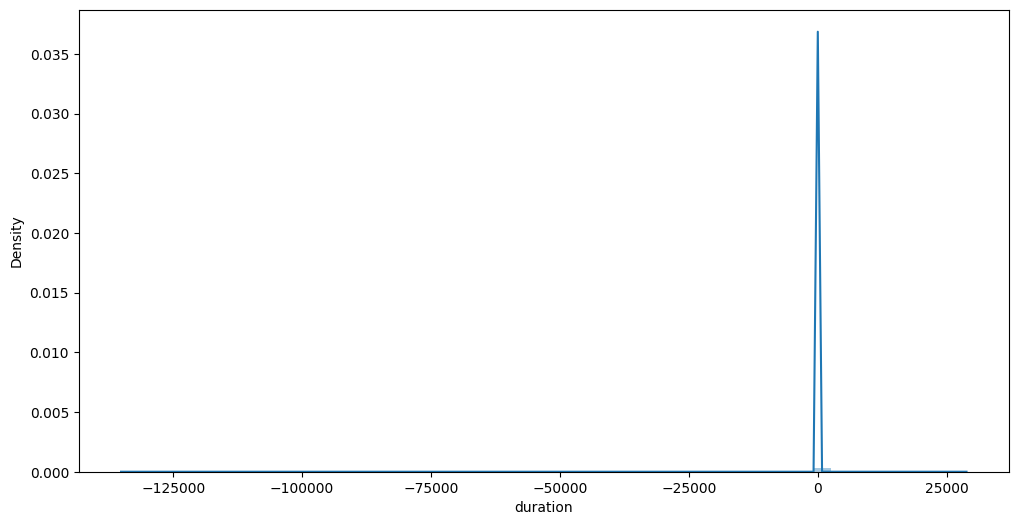

In [15]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)
sns.distplot(train_df.duration, ax=ax);

We notice that there are negative durations and trips that last 6 hours. \
We will proceed to remove outliers and narrow the scope to trips lasting between 1 minute and 1 hour.

In [16]:
MIN_DURATION = 1
MAX_DURATION = 60


def filter_outliers(df, min_duration=MIN_DURATION, max_duration=MAX_DURATION):
    df = df[df["duration"].between(min_duration, max_duration)]
    return df


train_df = filter_outliers(train_df)

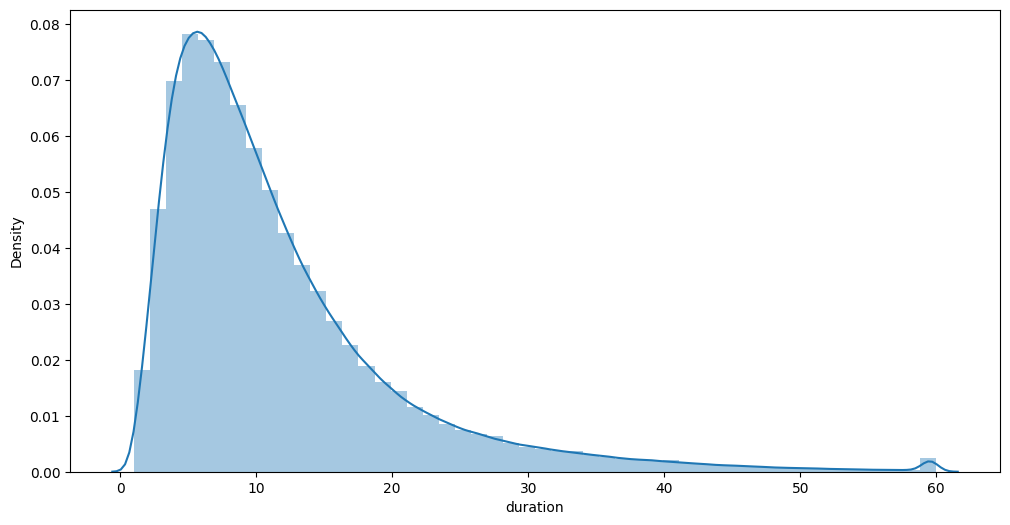

In [17]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)
sns.distplot(train_df.duration, ax=ax);

## 2-2 Prepare features

### 2-2-1 Categorical features

We will encode discrete variables as strings and then proceed to extracting the features and the target in order to train two models:

In [18]:
CATEGORICAL_COLS = ["PULocationID", "DOLocationID", "passenger_count"]


def encode_categorical_cols(df):
    df[CATEGORICAL_COLS] = df[CATEGORICAL_COLS].fillna(-1).astype("int")
    df[CATEGORICAL_COLS] = df[CATEGORICAL_COLS].astype("category")
    return df


train_df = encode_categorical_cols(train_df)

In [19]:
def extract_x_y(df, dv=None):
    dicts = df[CATEGORICAL_COLS].to_dict(orient="records")
    if dv is None:
        dv = DictVectorizer()
        dv.fit(dicts)
    X = dv.transform(dicts)
    y = df["duration"].values
    return X, y, dv


X_train, y_train, dv = extract_x_y(train_df)

# 3 - Train model

In [20]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [21]:
# ~ 2.5 minutes
rf = RandomForestRegressor(n_estimators=100, max_depth=11, max_features="sqrt", random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=11, max_features='sqrt', n_jobs=-1,
                      random_state=1)

# 4 - Evaluate model

In [22]:
def compute_metrics(y, y_pred):
    metrics = {
        "rmse": mean_squared_error(y, y_pred, squared=False),
        "mape": mean_absolute_percentage_error(y, y_pred),
    }
    return metrics

## 4-1 On train data

In [23]:
y_pred_lr = lr.predict(X_train)
y_pred_rf = rf.predict(X_train)
compute_metrics(y_train, y_pred_lr), compute_metrics(y_train, y_pred_rf)

({'rmse': 8.660509931523768, 'mape': 0.860562565627831},
 {'rmse': 6.84001794992596, 'mape': 0.6793811806006956})

## 4-2 On test data

In [24]:
test_df = pd.read_parquet(os.path.join(DATA_FOLDER, "yellow_tripdata_2021-02.parquet"))

In [25]:
test_df = compute_target(test_df)
test_df = filter_outliers(test_df)
test_df = encode_categorical_cols(test_df)
X_test, y_test, _ = extract_x_y(test_df, dv=dv)

In [26]:
y_pred_test_lr = lr.predict(X_test)
y_pred_test_rf = rf.predict(X_test)
compute_metrics(y_test, y_pred_test_lr), compute_metrics(y_test, y_pred_test_rf)

({'rmse': 9.11523598701252, 'mape': 0.7975360336730114},
 {'rmse': 7.458291090877386, 'mape': 0.6368212410979862})